In [1]:
import tensorflow as tf
import numpy as np
import os
import pathlib
import time
import datetime
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from IPython import display
import torch
import shutil
import  random

AUTOTUNE = tf.data.AUTOTUNE

Koristi se dataset Stanford Dogs Dataset, koji sadrzi slike 120 rasa pasa. Najcesce se koristi za klasifikaciju ili prepoznavanje
objekata, ali ovde cemo ga koristiti za prebacivanje crno-belih slika u slike sa bojom. Najpre cemo skinuti citav dataset, pa cemo kasnije izabrati 200 slika za treniranje i za testiranje.

In [2]:
dataset_name= 'images'

In [3]:
_URL = f'http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar'
path_to_zip = tf.keras.utils.get_file(
    fname=f"dogs.tar.gz",
    origin=_URL,
    extract=True)

path_to_zip  = pathlib.Path(path_to_zip)

PATH = path_to_zip.parent/dataset_name
PATH

WindowsPath('C:/Users/grmus/.keras/datasets/images')

Prebrojavanje broja slika u StanfordDogs dataset-u. Za treniranje bismo mogli da koristimo do 20580 slika, medjutim zbog zahtevnosti obucavanje date arhitekture korisceno je samo 200 slika za treniranje i 50 za testiranje.

In [4]:
totalFiles = 0
totalDir = 0
for base, dirs, files in os.walk(PATH):
    print('Searching in : ',base)
    for Files in files:
        totalFiles += 1
print('Totalni broj fajlova',totalFiles)

Searching in :  C:\Users\grmus\.keras\datasets\images
Searching in :  C:\Users\grmus\.keras\datasets\images\n02085620-Chihuahua
Searching in :  C:\Users\grmus\.keras\datasets\images\n02085782-Japanese_spaniel
Searching in :  C:\Users\grmus\.keras\datasets\images\n02085936-Maltese_dog
Searching in :  C:\Users\grmus\.keras\datasets\images\n02086079-Pekinese
Searching in :  C:\Users\grmus\.keras\datasets\images\n02086240-Shih-Tzu
Searching in :  C:\Users\grmus\.keras\datasets\images\n02086646-Blenheim_spaniel
Searching in :  C:\Users\grmus\.keras\datasets\images\n02086910-papillon
Searching in :  C:\Users\grmus\.keras\datasets\images\n02087046-toy_terrier
Searching in :  C:\Users\grmus\.keras\datasets\images\n02087394-Rhodesian_ridgeback
Searching in :  C:\Users\grmus\.keras\datasets\images\n02088094-Afghan_hound
Searching in :  C:\Users\grmus\.keras\datasets\images\n02088238-basset
Searching in :  C:\Users\grmus\.keras\datasets\images\n02088364-beagle
Searching in :  C:\Users\grmus\.kera

Searching in :  C:\Users\grmus\.keras\datasets\images\n02116738-African_hunting_dog
Totalni broj fajlova 20580


Samo cemo 200 slika koristiti za treniranje modela i njih cemo izdvojiti u posebne direktorijume  koji se nalaze u 
**datasets/StanfordDogs/train** , <br> odnosno  **datasets/StanfordDogs/test**

In [5]:
train_dir = "./datasets/StanfordDogs/train/"
test_dir = "./datasets/StanfordDogs/test/"
standford_dir = "./datasets/StanfordDogs/"
train_path = pathlib.Path(train_dir)
test_path = pathlib.Path(test_dir)
standford_path = pathlib.Path(standford_dir)
# Kreiramo ove direktorijume samo ako ne postoje, tj. ako je ovo prvo pokretanje ove radne sveske
if(not standford_path.exists()):
    print('Direktorijum StanfordDogs ne postoji. Kreiramo novi')
    os.mkdir('datasets/StanfordDogs')
    print('Kreiramo direktorijume za cuvanje slika koje koristimo za treniranje i testiranje')
    os.mkdir('datasets/StanfordDogs/train')
    os.mkdir('datasets/StanfordDogs/test')
else:
    if(not train_path.exists()):
        print('Pravimo direktorijum za cuvanje slika koje se koriste za treniranje')
        os.mkdir('datasets/StanfordDogs/train')
    if(not test_path.exists()):
        print('Pravimo direktorijum za cuvanje slika koje se koriste za testiranje')
        os.mkdir('datasets/StanfordDogs/test')

# Postavljanje broja slika koje ce se koristiti za treniranje.
# Ukoliko neko zeli da poveca ili da samnji skup za treniranje to moze uraditi ovde        
total_files = 250

Delimo slike na skup za treniranje i testiranje u odnosu 4:1. Ukupno ce biti korisceno 250 slika zbog potrebnog vremena da se obuci model na citavom skupu.

In [6]:
total_files = 250
from distutils.dir_util import copy_tree
i=0
for base, dirs, files in os.walk(PATH):
    if(i==total_files):
        break
    for f in files:
        if i%5==0:
            shutil.copy(base+"\\"+f, test_dir)
        else:    
            shutil.copy(base+"\\"+f, train_dir)
        i = i+1
        if(i==total_files):
            break


Uzimamo jedanu sliku i transformisemo je u crno-belu. Za to se koristi metod **tf.image.rgb_to_grayscale** . Posle koristimo **tf.image.grayscale_to_rgb**
da bi crno-bele slike bile istih dimenzija kao i slike u boji.

In [7]:
random_sample = random.choice(os.listdir(test_dir))
sample_image = tf.io.read_file(test_dir + random_sample)
sample_image = tf.io.decode_jpeg(sample_image)
input_image = tf.image.rgb_to_grayscale(sample_image)
input_image = tf.image.grayscale_to_rgb(input_image)

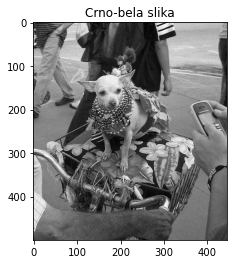

In [8]:
plt.figure()
plt.title('Crno-bela slika')
plt.imshow(input_image)

In [9]:
# funkcija za ucitavanje slike
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.io.decode_jpeg(image)
    
    
    input_image = tf.image.rgb_to_grayscale(image)
    input_image = tf.image.grayscale_to_rgb(input_image)
    # Converting both images to float32 tensors
    
    input_image = tf.cast(input_image,tf.float32)
    real_image = tf.cast(image,tf.float32)   
    
    return input_image, real_image

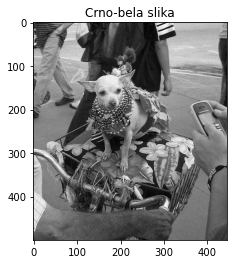

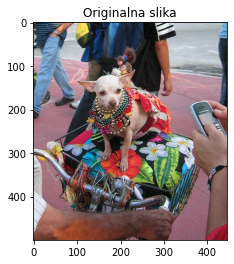

In [10]:
# Provera funkcije load
input_image , real_image = load(test_dir+random_sample)
# Casting to int for matplotlib to display the images
plt.figure()
plt.title('Crno-bela slika')
plt.imshow(input_image / 255.0)
plt.figure()
plt.title('Originalna slika')
plt.imshow(real_image / 255.0)

In [11]:
BUFFER_SIZE = 200
BATCH_SIZE = 1
# Dimenzije slike
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [12]:
# Funkcija za promenu dimenzije slike. I sirina i visina slike ce iznositi 256
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image

In [13]:
# Funkcija slucajnog odsecanja. 

def random_crop(input_image,real_image):
    statcked_image = tf.stack([input_image,real_image],axis=0)
    cropped_image = tf.image.random_crop(
        statcked_image,size=[2,IMG_HEIGHT,IMG_WIDTH,3])
    
    return cropped_image[0],cropped_image[1]

In [14]:
# Prebacivanje vrednosti tensora u opseg (-1,1)
def normalize(input_image,real_image):
    input_image = (input_image/127.5)-1
    real_image = (real_image/127.5)-1    
    
    return input_image, real_image

In [15]:
# Dodajemo nasumicno dodavanje suma. To jest, prvo cemo da isecemo sliku, a zatim je nasumicno preslikavamo.
@tf.function()
def random_jitter(input_image,real_image):
    
    input_image, real_image = resize(input_image,real_image,286,286)
    input_image, real_image = random_crop(input_image,real_image)
    
    if tf.random.uniform(())>0.5:
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)
    return input_image,real_image

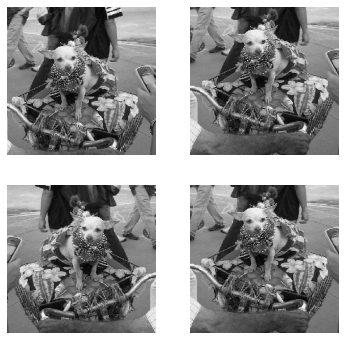

In [16]:
plt.figure(figsize=(6, 6))
for i in range(4):
    rj_inp, rj_re = random_jitter(input_image, real_image)
    plt.subplot(2, 2, i + 1)
    plt.imshow(rj_inp / 255.0)
    plt.axis('off')
plt.show()

In [17]:
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image,real_image)
    input_image, real_image = normalize(input_image,real_image)

    
    return input_image, real_image
    

In [18]:
def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image,real_image,
                                    IMG_HEIGHT,IMG_WIDTH)
    input_image, real_image = normalize(input_image,real_image)
    
    return input_image, real_image

In [19]:
# Kreiranje skupa za treniranje. Koriscenja je funkcija load_image_train koja u sebi ima
# odsecanje slike i random rotiranje slike 
train_dataset = tf.data.Dataset.list_files(train_dir+"*.jpg")
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [20]:
test_dataset = tf.data.Dataset.list_files(test_dir+"*.jpg")
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.shuffle(BUFFER_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

# Kreiranje Genratora

Generator je modifikovan U-Net konvoluciona mreza, koja je prvobitno koriscnjena u biomedicini za segmentaciju objekata na slici.
<br>U-Net mreza se sastoji od enkodra i dekodera: <br>

- svaki blok u enkoderu se sastoji od : konvolucionog dela ->unutrasnje standardizacije ->Leaky ReLu
- svaki blok u dekoderu se sastoji od : transponovanog konvolucionog dela ->unutrasnje standardizacije->regularizacije izostavljanjem
- postoje direktne veze izmedju enkodera i dekodera

In [21]:
OUTPUT_CHANNELS = 3

In [22]:
def downsample(filters,size,apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0.,0.12)
    
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters,size,strides=2,padding='same',
                              kernel_initializer=initializer,use_bias=False))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    
    return result

In [23]:
def upsample(filters,size,apply_dropout=False):
    initializer = tf.random_normal_initializer(0.,0.12)
    
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters,size,strides=2,padding='same',
                                       kernel_initializer=initializer,
                                       use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    
    return result

In [24]:
def Generator():
    
    inputs = tf.keras.layers.Input(shape=[256,256,3])
    
    down_stack= [
        downsample(64,4,apply_batchnorm=False),
        downsample(128,4),
        downsample(256,4),
        downsample(512,4),
        downsample(512,4),
        downsample(512,4),
        downsample(512,4),
        downsample(512,4)     
        ]
    
    up_stack = [
        upsample(512,4,apply_dropout=True),
        upsample(512,4,apply_dropout=True),
        upsample(512,4,apply_dropout=True),
        upsample(512,4),
        upsample(256,4),
        upsample(128,4),
        upsample(64,4)        
    ]
    
    initializer = tf.random_normal_initializer(0.,0.12)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS,4,
                                          strides=2,padding='same',
                                          kernel_initializer=initializer,activation='tanh')
    
    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips =reversed(skips[:-1])
    
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])
        
    x = last(x)
    
    
    return tf.keras.Model(inputs=inputs,outputs=x)

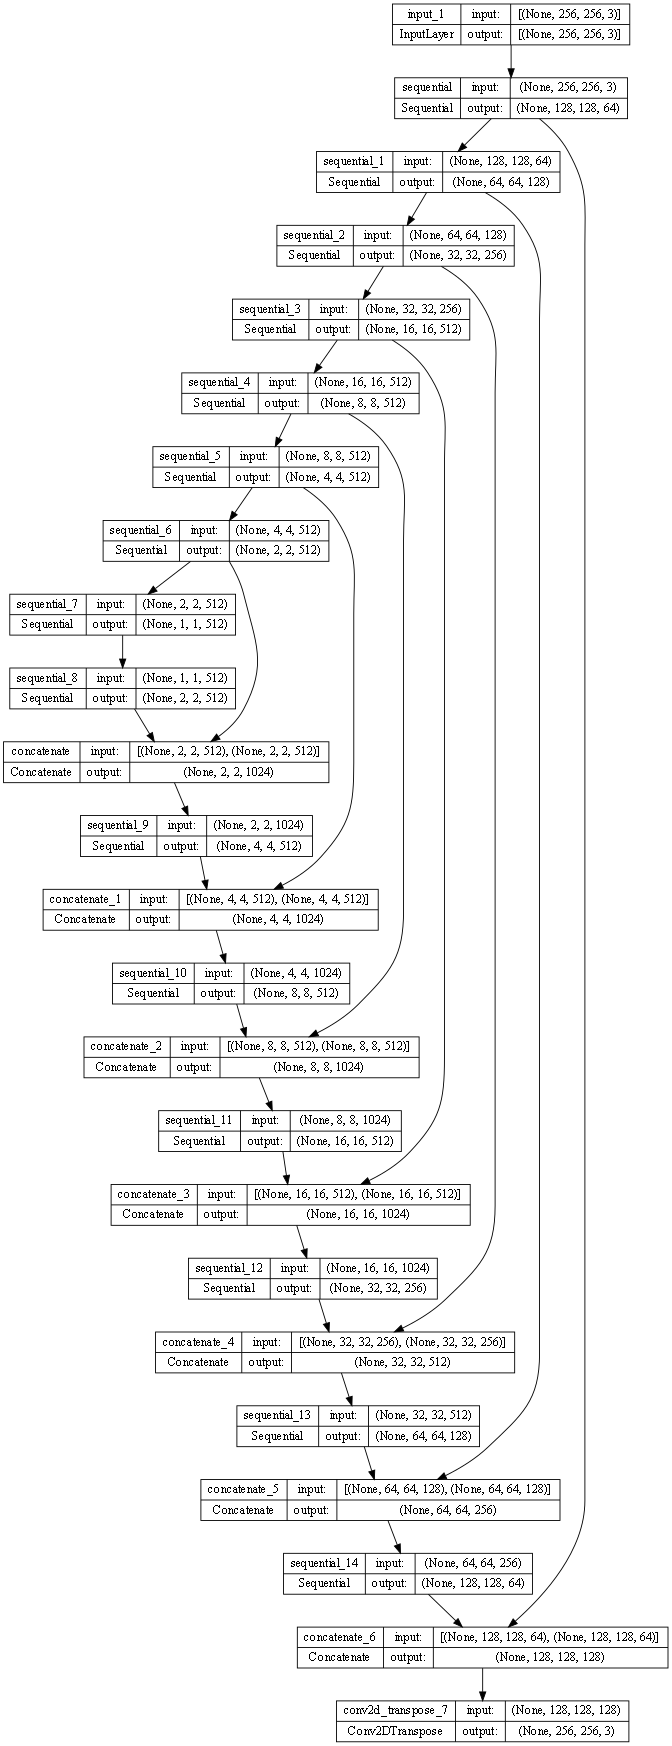

In [25]:
generator = Generator()
tf.keras.utils.plot_model(generator,to_file="./models/04-pix2pix-LargeDataset/generator.png",show_shapes=True,dpi=64)

In [26]:
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 128, 128, 64  3072        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 sequential_1 (Sequential)      (None, 64, 64, 128)  131584      ['sequential[0][0]']             
                                                                                              

In [27]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

Obucavanje genetartora izgleda ovako

<img src="images/generator_pix2pix.png"  width="400" hight="400">

In [28]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

# Diskriminator 

Diskriminator je konvolutivni PatchGAN klasifikator. On pokusava da klasifikuje da li je svaki NxN deo  slike pravi ili generisani.
- svaki blok u diskriminatoru se sastoji od : konvulitivnog dela ->unutrasnje standardizacije ->Leaky ReLu
- diskriminator prima 2 ulaza:
     - ulazna slika i ciljna slika koja bi trebala da bude klasifikovana kao prava
     - ulazna slika i generisana slika koja bi trebalo da bude klasifikovana kao lazna
     - ova dva ulaza se spajaju u jedan koriscenjem tf.concat metode
     

In [29]:
def Discriminator():
    initializer = tf.random_normal_initializer(0.,0.12)
    
    inp = tf.keras.layers.Input(shape=[256,256,3],name="input_image")
    tar = tf.keras.layers.Input(shape=[256,256,3],name="target_image")
    
    x = tf.keras.layers.concatenate([inp,tar])
    
    down1 = downsample(64,4,False)(x)
    down2 = downsample(128,4)(down1)
    down3 = downsample(256,4)(down2)
    
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)
    conv = tf.keras.layers.Conv2D(512,4,
                                 strides=1,
                                 kernel_initializer=initializer,
                                 use_bias=False)(zero_pad1)
    
    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
    
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
    
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)
    
    last = tf.keras.layers.Conv2D(1,4,strides=1,
                                 kernel_initializer=initializer)(zero_pad2)
    
    return tf.keras.Model(inputs=[inp,tar],outputs=last)

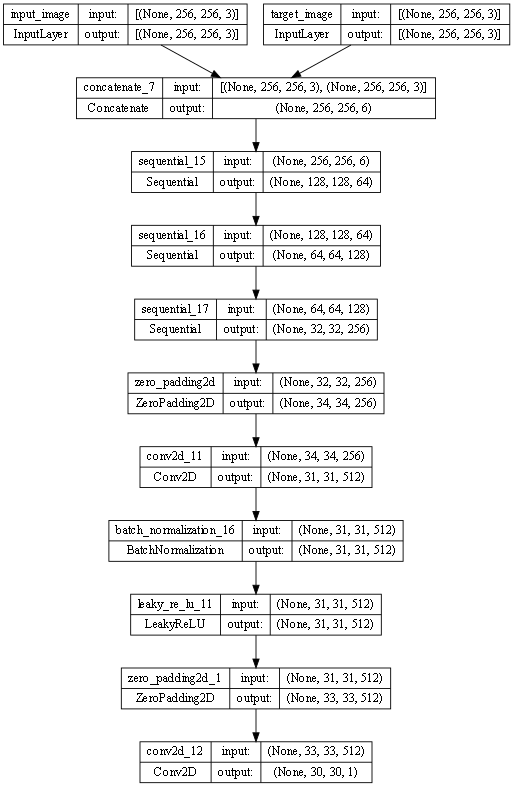

In [30]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator,to_file="./models/04-pix2pix-LargeDataset/diskriminator.png",show_shapes=True,dpi=64)

In [31]:
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 target_image (InputLayer)      [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_7 (Concatenate)    (None, 256, 256, 6)  0           ['input_image[0][0]',            
                                                                  'target_image[0][0]']     

Funkcija greske za diskriminator
-  funkcija greske za diskriminator za ulaz dobija dve slike: originalnu sliku i generisanu
-  real_loss je sigmoidna unakrsna entropija izmedju prave slike i niza jedinica
-  generated_loss je sigmoidna unakrsna entropija izmedju generisane slike i niza nula
-  ukupna greska je zbir prethodne dve

<img src="images/diskriminator_pix2pix.png"  width="400" hight="400">

In [32]:
def discriminator_loss(disc_real_output,disc_generated_output):
    real_loss= loss_object(tf.ones_like(disc_real_output),disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output),disc_generated_output)
    total_loss = real_loss+generated_loss
    
    return total_loss

In [33]:
# Podesavanje optimizatora. Koristi se i L1 regularizacija
generator_optimizer = tf.keras.optimizers.Adam(2e-4,beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4,beta_1=0.5)

Podesavanje checkpoint-a da bismo mogli da prekidamo i nastavljamo treniranje.

In [34]:
checkpoint_dir = './checkpoints/04-pix2pix/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,"ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                discriminator_optimizer=discriminator_optimizer,
                                generator=generator,
                                discriminator= discriminator)

In [35]:
def generate_images(model,test_input,tar):
    prediction = model(test_input,training=True)
    plt.figure(figsize=(15,15))
    
    display_list = [test_input[0],tar[0],prediction[0]]
    title = ['Crno-Bela slika', 'Slika U Boji', 'Generisana Slika']
    for i in range(3):
        plt.subplot(1,3,i+1)
        plt.title(title[i])
        plt.imshow(display_list[i]*0.5+0.5)
        plt.axis('off')
        
    plt.show()

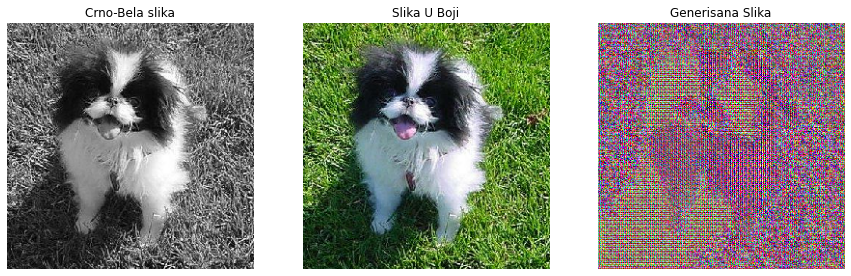

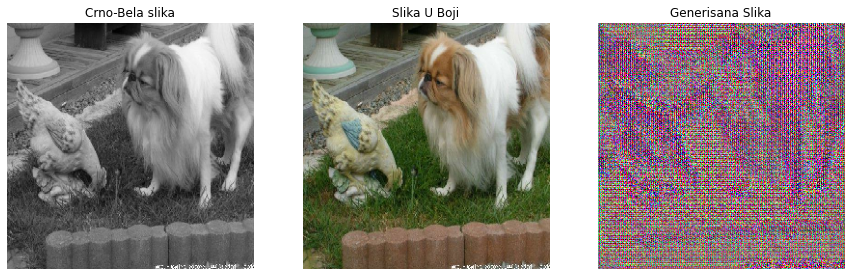

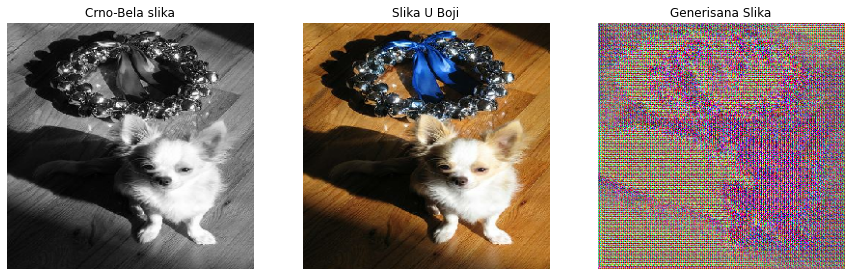

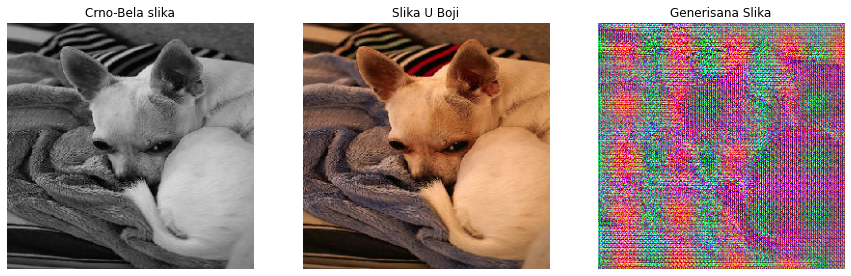

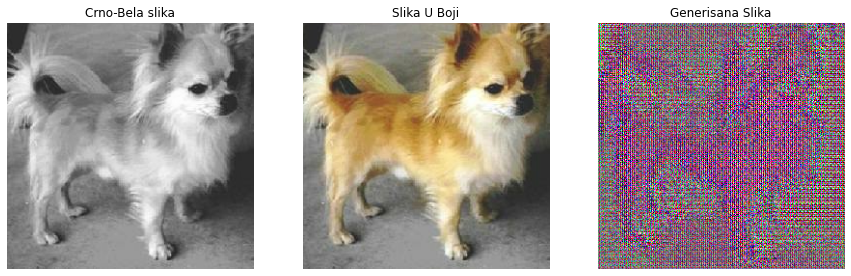

In [36]:
for example_input, example_target in train_dataset.take(5):
    generate_images(generator,example_input,example_target)

In [37]:
log_dir = "logs/04-pix2pix"

summary_writer = tf.summary.create_file_writer(
    log_dir + "fit/"+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [38]:
@tf.function
def train_step(input_image,target,step):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image,training=True)
        
        disc_real_output = discriminator([input_image,target],training=True)
        disc_generated_output = discriminator([input_image,gen_output],training=True)
        
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output,gen_output,target)
        disc_loss = discriminator_loss(disc_real_output,disc_generated_output)
        
    generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,discriminator.trainable_variables)
    
    
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,discriminator.trainable_variables))
    
    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss',gen_total_loss,step= step//1000)
        tf.summary.scalar('gen_gan_loss',gen_gan_loss,step= step//1000)
        tf.summary.scalar('gen_l1_loss',gen_l1_loss,step= step//1000)
        tf.summary.scalar('disc_loss',disc_loss,step= step//1000)
    return  gen_total_loss , gen_gan_loss , gen_l1_loss , disc_loss
        

In [39]:
# Inicijalizovanje skupova za sakupljanje podataka o funkciji greske 
gen_total_loss_list = []
gen_gan_loss_list = []
gen_l1_loss_list = []
disc_loss_list=[]

In [40]:
def fit(train_ds, test_ds, steps):
    example_input, example_target = next(iter(test_ds.take(1)))
    start = time.time()
    i=0
    for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
        if (i % 1000 == 0):
            display.clear_output(wait=True)

            if i != 0:
                print(f'Vreme potrebno za  1000 koraka: {time.time()-start:.2f} sec\n')

            start = time.time()
        
            generate_images(generator, example_input, example_target)
            print(f"Korak: {i//1000}.")
        i = i+1
        gen_total_loss , gen_gan_loss , gen_l1_loss , disc_loss = train_step(input_image, target, step)
        if (i % 1000 ==0): 
            # Ponovo cemo na svakih 1000 koraka upisivati vrednosti gresaka da bi nam grafika izgledao bolje
            gen_total_loss_list.append(gen_total_loss)
            gen_gan_loss_list.append(gen_gan_loss)
            gen_l1_loss_list.append(gen_l1_loss)
            disc_loss_list.append(disc_loss)
    # Training step
        if (i+1) % 10 == 0:
            print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
        if (i + 1) % 5000 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

Vreme potrebno za  1000 koraka: 53.59 sec



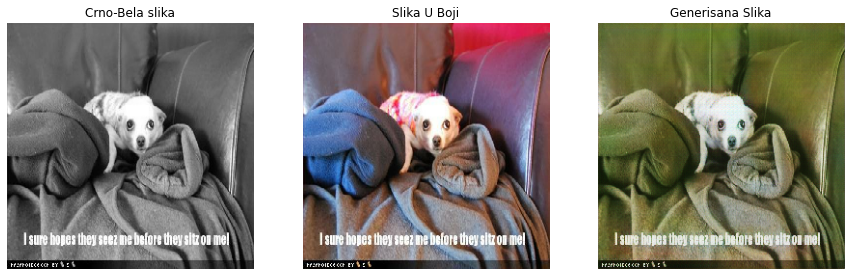

Korak: 49.
....................................................................................................

In [41]:
fit(train_dataset,test_dataset,steps=50_000)

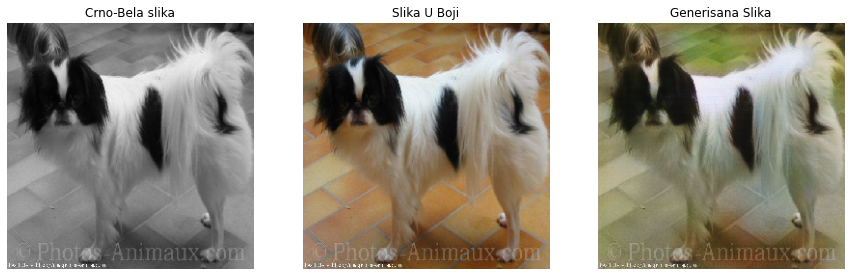

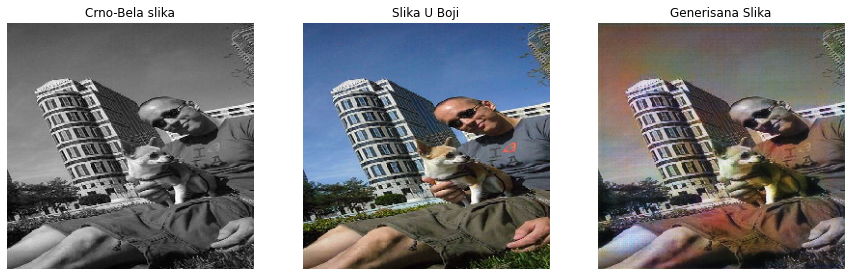

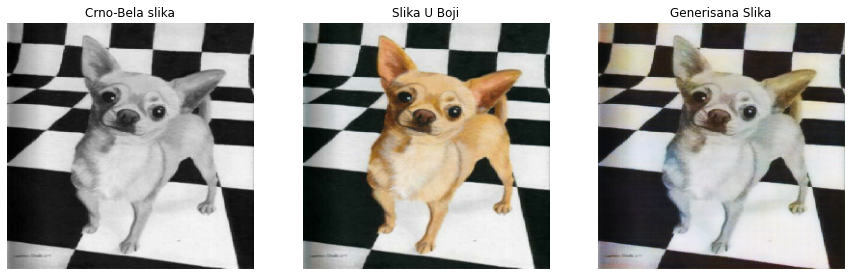

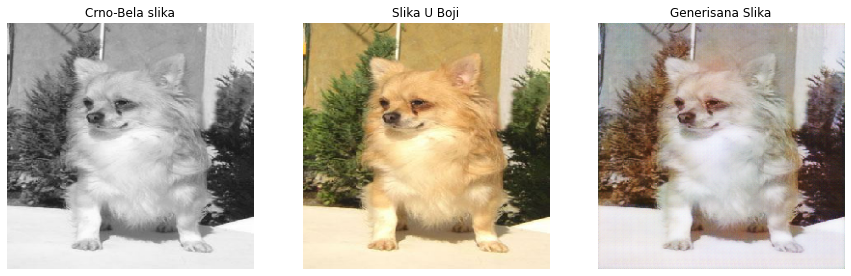

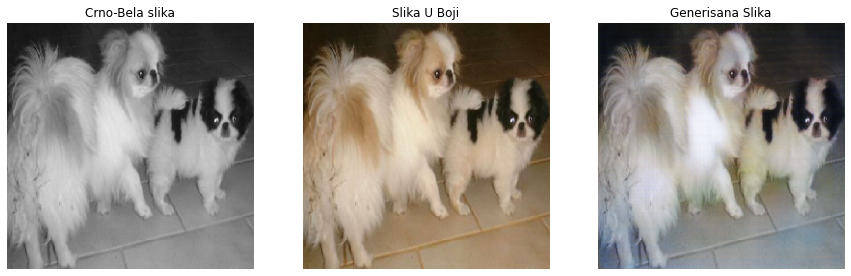

In [42]:
for inp, tar in test_dataset.take(5):
    generate_images(generator, inp, tar)

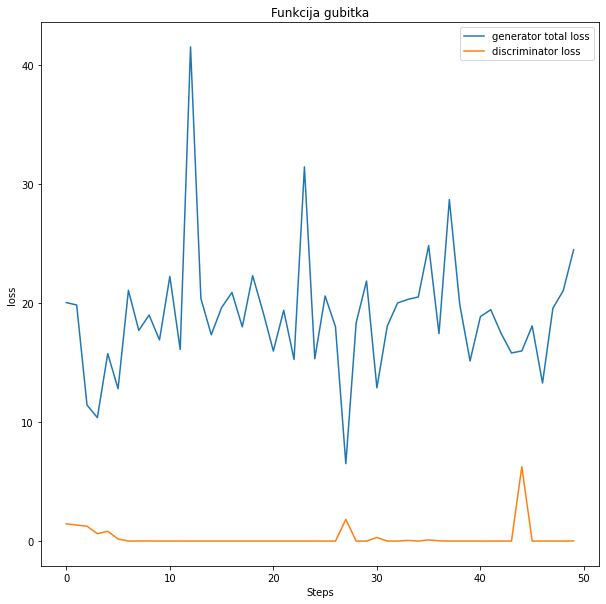

In [43]:
plt.figure(figsize=(10,10))
plt.title('Funkcija gubitka')
plt.xlabel('Steps')
plt.ylabel('loss')
plt.plot(np.arange(0,len(gen_gan_loss_list)), gen_total_loss_list, label='generator total loss')
plt.plot(np.arange(0,len(disc_loss_list)), disc_loss_list, label='discriminator loss')
plt.legend(loc='best')
plt.show()

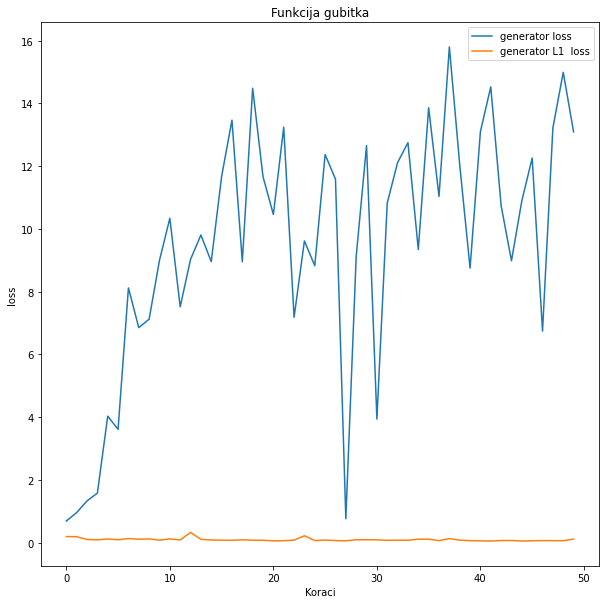

In [44]:
plt.figure(figsize=(10,10))
plt.title('Funkcija gubitka')
plt.xlabel('Koraci')
plt.ylabel('loss')
plt.plot(np.arange(0,len(gen_gan_loss_list)), gen_gan_loss_list, label='generator loss')
plt.plot(np.arange(0,len(gen_l1_loss_list)), gen_l1_loss_list, label='generator L1  loss')
plt.legend(loc='best')
plt.show()

Posto je obucavanje modela zahtevno, koristi se checkpoint-i da bi se proces treniranja mogao nastaviti u bilo kom drugom trenutku.

In [45]:
# Ucitavanje poslednjeg checkpoint-a
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Cuvanje generatora i diskriminatora za narednu upotrebu

In [46]:
generator.save('models/04-pix2pix-LargeDataset/generator.h5')
discriminator.save('models/04-pix2pix-LargeDataset/discriminator.h5')